# MLS Player Performance Review


## Overview

Major League Soccer Player's Association(MLSPA) has been keeping salary data on its players for years and would like to utilize that data with player's statistics data to evaluate player performance and its relationship to player salary. By anazlying this data, I hope to create a predictive model that can highlight this link and the particular aspects of player performance that are most tied to salary. 

## Business Problem

MLS has growing rapidly and gaining in popularity, increasing their number of teams from just 13 in 2007 to 29 today. Likewise, the average team revenue increased from  37 million USD in 2008 to 579 million USD in 2022. https://huddleup.substack.com/p/how-lafc-became-major-league-soccers This also saw an increase in player salary over the years. In order to figure out what a player's salary should be, I analyzed a player's statistics by year in order to come up with recommendations to further bolster future analysis.

## Data Understanding
The statistics datasets in this analysis come from Mlssoccer.com, provided via a source on Kaggle who used webscraping before the website changed how it displayed information.https://www.kaggle.com/datasets/josephvm/major-league-soccer-dataset The salary datasets come directly from the MLSPA(Major League Soccer Players Association) on mlsplayers.org. I analyzed over 6000 players from the combined dataframe of these sources ranging from 2007-2022.

The statsistics datasets were csv files containing information about a field player's performance on during a season. The field  dataset includes information such as goals, assists, games played, total minutes played, and more.


## Data Preparation

MLS wants to continue to expand and entice players the likes of Lionel Messi into the league. In order to understand the current salaries of players in the league, I combined the statistics and salary datasets.

I trained a Linear Regression Model, Random Forest Regression Model, and KNearestNeighbors Regression Model. I utilized a Pipeline and GridSearch for each of these to crossvalidate scores and iterate over many different models. I added and modified several feature columns, including Penaly Kick Conversion Rates, whether a player made the Postseason, a one-hot encoded breakdown of player position, and more. My final dataframe contained XX features that were used by these models to more accurately predict Player salary. I used r2 score, MSE, RMSE, and MAE to help evaluate how well my models were performing, but ultimately looked at r2 score and RMSE as my most important metrics to measure how far off a model was predicting salary. 

### Imports

In [2]:
import pandas as pd
import os
from rapidfuzz import fuzz
import re
from unidecode import unidecode
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.datasets import make_blobs
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import r2_score, silhouette_score, mean_squared_error, mean_absolute_error 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from IPython.display import Image
from sklearn.inspection import permutation_importance

### Reading Data
These datasets are directly inside the repository and are accessed using the below code.

In [3]:
# Loading csv files into dataframes
player_stats_df = pd.read_csv('./data/Player_stats/all_players.csv')
keeper_stats_df = pd.read_csv('./data/Player_stats/all_goalkeepers.csv')

### Data Cleaning


 PKG/A needs to be changed as it is fractions in the form of strings.

In [4]:
keeper_stats_df.head()

,Player,Club,POS,GP,GS,MINS,SHTS,SV,GA,GAA,PKG/A,W,L,T,ShO,W%,Sv%,Year,Season
0,Mark Dodd,DAL,GK,31,31,2776,235,160,45,1.45,5/5,17,14,0,6,54.8,68.1,1996,reg
1,Tony Meola,MET,GK,29,29,2610,188,142,38,1.31,3/4,14,15,0,9,48.3,75.5,1996,reg
2,Mark Dougherty,TB,GK,28,28,2520,186,123,47,1.68,9/10,17,11,0,3,60.7,66.1,1996,reg
3,Jorge Campos,LA,GK,24,24,2160,133,100,27,1.13,0/1,13,8,0,4,54.2,75.2,1996,reg
4,Garth Lagerwey,KC,GK,23,22,1959,133,83,38,1.73,2/2,12,10,0,3,52.2,62.4,1996,reg


I Will be dropping the Club column entirely, so there are no other nulls to deal with in keeper_stats_df.

In [5]:
keeper_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  2006 non-null   object 
 1   Club    1324 non-null   object 
 2   POS     2006 non-null   object 
 3   GP      2006 non-null   int64  
 4   GS      2006 non-null   int64  
 5   MINS    2006 non-null   int64  
 6   SHTS    2006 non-null   int64  
 7   SV      2006 non-null   int64  
 8   GA      2006 non-null   int64  
 9   GAA     2006 non-null   float64
 10  PKG/A   2006 non-null   object 
 11  W       2006 non-null   int64  
 12  L       2006 non-null   int64  
 13  T       2006 non-null   int64  
 14  ShO     2006 non-null   int64  
 15  W%      2006 non-null   float64
 16  Sv%     2006 non-null   float64
 17  Year    2006 non-null   int64  
 18  Season  2006 non-null   object 
dtypes: float64(3), int64(11), object(5)
memory usage: 297.9+ KB


In [6]:
keeper_stats_df.describe()

,GP,GS,MINS,SHTS,SV,GA,GAA,W,L,T,ShO,W%,Sv%,Year
count,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000,2006.000000
mean,6.804586,6.677966,603.997009,33.926720,23.310568,9.608175,0.888500,2.629611,2.626620,1.420738,1.606680,18.861316,37.418096,2010.110668
std,10.316232,10.292286,924.747438,52.330135,36.569597,14.673335,0.992154,4.433369,4.090945,2.753633,2.855163,24.494023,34.628706,7.284097
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1996.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2004.000000
50%,1.000000,1.000000,90.000000,7.000000,4.000000,2.000000,0.940000,0.000000,1.000000,0.000000,0.000000,0.000000,52.700000,2011.000000
75%,9.000000,8.000000,770.250000,47.000000,31.000000,13.750000,1.500000,3.000000,3.000000,1.000000,2.000000,37.500000,68.900000,2016.750000
max,34.000000,34.000000,3060.000000,249.000000,184.000000,64.000000,6.000000,22.000000,19.000000,18.000000,16.000000,100.000000,100.000000,2020.000000


In [7]:
player_stats_df.head()

,Player,Club,POS,GP,GS,MINS,G,A,SHTS,SOG,...,RdA,A/90min,FC,FS,OFF,YC,RC,SOG%,Year,Season
0,Roy Lassiter,TB,F,30,30,2580,27,4,76,49,...,2,0.14,20,39,70,2,0,64.47,1996,reg
1,Raul Diaz Arce,DC,F,28,28,2351,23,2,100,49,...,2,0.08,32,26,35,6,1,49.00,1996,reg
2,Eduardo Hurtado,LA,F,26,26,2323,21,7,87,56,...,3,0.27,48,26,25,5,0,64.37,1996,reg
3,Preki,KC,M,32,32,2880,18,13,140,61,...,4,0.41,26,44,7,3,0,43.57,1996,reg
4,Brian McBride,CLB,F,28,28,2307,17,3,79,44,...,1,0.12,21,46,10,0,0,55.70,1996,reg


A lot of columns to analyze, but no nulls since Club will be dropped entirely

In [8]:
player_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15767 entries, 0 to 15766
Data columns (total 28 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Player   15767 non-null  object 
 1   Club     10274 non-null  object 
 2   POS      15767 non-null  object 
 3   GP       15767 non-null  int64  
 4   GS       15767 non-null  int64  
 5   MINS     15767 non-null  int64  
 6   G        15767 non-null  int64  
 7   A        15767 non-null  int64  
 8   SHTS     15767 non-null  int64  
 9   SOG      15767 non-null  int64  
 10  GWG      15767 non-null  int64  
 11  PKG/A    15767 non-null  object 
 12  HmG      15767 non-null  int64  
 13  RdG      15767 non-null  int64  
 14  G/90min  15767 non-null  float64
 15  SC%      15767 non-null  float64
 16  GWA      15767 non-null  int64  
 17  HmA      15767 non-null  int64  
 18  RdA      15767 non-null  int64  
 19  A/90min  15767 non-null  float64
 20  FC       15767 non-null  int64  
 21  FS       157

I had to filter the statistics dataframe down to just the years 2007-2020 since that is the furthest back I was able to access
salary data. Consequently it is also the year the Designated Player rule (commonly referred to as the "Beckham rule" ) was first implemented; it is credited as the most important catalyst that spurred the beginning of the rapid expansion of MLS. 

In [9]:
#Creating a list of the years we want to use from the dataframes. Salary data is only accessible back to 2007.
years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

In [10]:
#Filtering dataframes to only show years in the years list
player_stats_df = player_stats_df[player_stats_df['Year'].isin(years)]
keeper_stats_df = keeper_stats_df[keeper_stats_df['Year'].isin(years)]

In [11]:
player_stats_df

,Player,Club,POS,GP,GS,MINS,G,A,SHTS,SOG,...,RdA,A/90min,FC,FS,OFF,YC,RC,SOG%,Year,Season
3029,Luciano Emilio,DC,F,29,28,2410,20,1,79,47,...,0,0.04,35,39,21,2,0,59.49,2007,reg
3030,Juan Pablo Angel,NY,F,24,24,2125,19,5,97,53,...,2,0.21,31,20,42,2,1,54.64,2007,reg
3031,Taylor Twellman,NE,F,26,25,2283,16,3,90,55,...,1,0.12,13,41,21,2,0,61.11,2007,reg
3032,Eddie Johnson,KC,F,24,24,2149,15,6,75,43,...,3,0.25,21,57,50,6,0,57.33,2007,reg
3033,Maykel Galindo,CHV,F,28,24,2021,12,5,55,28,...,2,0.22,44,53,30,6,0,50.91,2007,reg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15762,Alejandro Pozuelo,NaN,M,1,1,120,0,0,5,0,...,0,0.00,2,0,0,0,0,0.00,2020,post
15763,Franco Jara,NaN,F,2,2,210,0,0,5,1,...,0,0.00,6,2,3,0,0,20.00,2020,post
15764,Andy Polo,NaN,M,1,1,105,0,0,6,3,...,0,0.00,0,3,0,0,0,50.00,2020,post
15765,Cristian Roldan,NaN,M,4,4,360,0,0,6,1,...,0,0.00,5,11,0,0,0,16.67,2020,post


In [12]:
player_stats_df['Season'].value_counts()

Season
reg     7245
post    3727
Name: count, dtype: int64

I'm going to remove the season column here but before I do that would like to add a feature that tells whether a player made it to the postseason or not for both dataframes.

In [13]:
grouped = player_stats_df.groupby(['Player', 'Year'])
made_postseason = grouped['Season'].nunique()

made_postseason = made_postseason.reset_index()
made_postseason.columns = ['Player', 'Year', 'Postseason']

player_stats_df = player_stats_df.merge(made_postseason, on=['Player', 'Year'])
player_stats_df['Postseason'] = player_stats_df['Postseason'].map({2:1, 1:0})
player_stats_df


,Player,Club,POS,GP,GS,MINS,G,A,SHTS,SOG,...,A/90min,FC,FS,OFF,YC,RC,SOG%,Year,Season,Postseason
0,Luciano Emilio,DC,F,29,28,2410,20,1,79,47,...,0.04,35,39,21,2,0,59.49,2007,reg,1
1,Luciano Emilio,NaN,F,2,1,77,0,0,2,2,...,0.00,0,1,0,0,0,100.00,2007,post,1
2,Juan Pablo Angel,NY,F,24,24,2125,19,5,97,53,...,0.21,31,20,42,2,1,54.64,2007,reg,1
3,Juan Pablo Angel,NaN,F,2,2,154,0,0,7,4,...,0.00,5,3,2,0,0,57.14,2007,post,1
4,Taylor Twellman,NE,F,26,25,2283,16,3,90,55,...,0.12,13,41,21,2,0,61.11,2007,reg,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10967,Siem de Jong,CIN,M,15,8,793,0,0,18,5,...,0.00,7,8,1,0,0,27.78,2020,reg,0
10968,Maxime Chanot,NYC,D,20,20,1712,0,0,19,4,...,0.00,18,6,1,5,1,21.05,2020,reg,1
10969,Maxime Chanot,NaN,D,1,1,120,1,0,2,1,...,0.00,1,1,0,0,0,50.00,2020,post,1
10970,Nicolas Figal,MIA,D,21,21,1746,0,0,22,9,...,0.00,22,26,0,4,0,40.91,2020,reg,1


In [14]:
k_grouped = keeper_stats_df.groupby(['Player', 'Year'])
made_postseason = k_grouped['Season'].nunique()

made_postseason = made_postseason.reset_index()
made_postseason.columns = ['Player', 'Year', 'Postseason']

keeper_stats_df = keeper_stats_df.merge(made_postseason, on=['Player', 'Year'])
keeper_stats_df['Postseason'] = keeper_stats_df['Postseason'].map({2:1, 1:0})
keeper_stats_df

,Player,Club,POS,GP,GS,MINS,SHTS,SV,GA,GAA,PKG/A,W,L,T,ShO,W%,Sv%,Year,Season,Postseason
0,Bouna Coundoul,COL,GK,30,30,2668,158,120,32,1.07,2/2,9,12,8,9,30.0,75.9,2007,reg,0
1,Kevin Hartman,KC,GK,30,30,2700,159,110,45,1.50,6/7,11,12,7,5,36.7,69.2,2007,reg,1
2,Kevin Hartman,NaN,GK,3,3,270,17,14,2,0.67,0/0,1,1,1,2,33.3,82.4,2007,post,1
3,Matt Reis,NE,GK,30,30,2700,169,120,43,1.43,3/3,14,8,8,10,46.7,71.0,2007,reg,1
4,Matt Reis,NaN,GK,4,4,360,27,24,2,0.50,0/0,2,1,1,3,50.0,88.9,2007,post,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1358,Elliot Panicco,NaN,GK,0,0,0,0,0,0,0.00,0/0,0,0,0,0,0.0,0.0,2020,post,1
1359,Eric Dick,SKC,GK,0,0,0,0,0,0,0.00,0/0,0,0,0,0,0.0,0.0,2020,reg,1
1360,Eric Dick,NaN,GK,0,0,0,0,0,0,0.00,0/0,0,0,0,0,0.0,0.0,2020,post,1
1361,Stefan Cleveland,SEA,GK,0,0,0,0,0,0,0.00,0/0,0,0,0,0,0.0,0.0,2020,reg,1


I am removing postseason data from the dataset as it is a smaller subset and effectively duplicates players that made it to the postseason for that particular year.

In [15]:
# Filtering dataframes to only have data from the regular season
player_stats_df = player_stats_df[player_stats_df['Season'] == 'reg']
keeper_stats_df = keeper_stats_df[keeper_stats_df['Season'] == 'reg']

In [16]:
player_stats_df

,Player,Club,POS,GP,GS,MINS,G,A,SHTS,SOG,...,A/90min,FC,FS,OFF,YC,RC,SOG%,Year,Season,Postseason
0,Luciano Emilio,DC,F,29,28,2410,20,1,79,47,...,0.04,35,39,21,2,0,59.49,2007,reg,1
2,Juan Pablo Angel,NY,F,24,24,2125,19,5,97,53,...,0.21,31,20,42,2,1,54.64,2007,reg,1
4,Taylor Twellman,NE,F,26,25,2283,16,3,90,55,...,0.12,13,41,21,2,0,61.11,2007,reg,1
6,Eddie Johnson,KC,F,24,24,2149,15,6,75,43,...,0.25,21,57,50,6,0,57.33,2007,reg,1
8,Maykel Galindo,CHV,F,28,24,2021,12,5,55,28,...,0.22,44,53,30,6,0,50.91,2007,reg,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10963,Sebastian Mendez,ORL,M,19,11,1087,0,0,17,3,...,0.00,32,9,1,4,1,17.65,2020,reg,1
10965,Kelyn Rowe,NE,M,16,10,896,0,0,17,4,...,0.00,13,4,0,3,0,23.53,2020,reg,1
10967,Siem de Jong,CIN,M,15,8,793,0,0,18,5,...,0.00,7,8,1,0,0,27.78,2020,reg,0
10968,Maxime Chanot,NYC,D,20,20,1712,0,0,19,4,...,0.00,18,6,1,5,1,21.05,2020,reg,1


In [17]:
keeper_stats_df

,Player,Club,POS,GP,GS,MINS,SHTS,SV,GA,GAA,PKG/A,W,L,T,ShO,W%,Sv%,Year,Season,Postseason
0,Bouna Coundoul,COL,GK,30,30,2668,158,120,32,1.07,2/2,9,12,8,9,30.0,75.9,2007,reg,0
1,Kevin Hartman,KC,GK,30,30,2700,159,110,45,1.50,6/7,11,12,7,5,36.7,69.2,2007,reg,1
3,Matt Reis,NE,GK,30,30,2700,169,120,43,1.43,3/3,14,8,8,10,46.7,71.0,2007,reg,1
5,Joe Cannon,LA,GK,29,29,2610,171,119,46,1.59,4/5,9,13,7,5,31.0,69.6,2007,reg,0
6,Troy Perkins,DC,GK,29,29,2610,155,117,32,1.10,1/3,16,6,7,8,55.2,75.5,2007,reg,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,Emmanuel Ochoa,SJ,GK,0,0,0,0,0,0,0.00,0/0,0,0,0,0,0.0,0.0,2020,reg,1
1355,Drake Callender,MIA,GK,0,0,0,0,0,0,0.00,0/0,0,0,0,0,0.0,0.0,2020,reg,1
1357,Elliot Panicco,NSH,GK,0,0,0,0,0,0,0.00,0/0,0,0,0,0,0.0,0.0,2020,reg,1
1359,Eric Dick,SKC,GK,0,0,0,0,0,0,0.00,0/0,0,0,0,0,0.0,0.0,2020,reg,1


The bulk of the data cleaning comes in for the salary dataframes which I am loading in here. I first identified what differences in column names the datasets had and got them to a place of uniformity.

In [18]:
# Loading in all the salary datasets into respective dataframes
salary2007_df = pd.read_excel('./data/Salary_data/2007-Salaries.xlsx', header=0)
salary2008_df = pd.read_excel('./data/Salary_data/2008-Salaries.xlsx', header=0)
salary2009_df = pd.read_excel('./data/Salary_data/2009-Salaries.xlsx', header=0)
salary2010_df = pd.read_excel('./data/Salary_data/2010-Salaries.xlsx', header=0)
salary2011_df = pd.read_excel('./data/Salary_data/2011-Salaries.xlsx', header=1)
salary2012_df = pd.read_excel('./data/Salary_data/2012-Salaries.xlsx', header=1)
salary2013_df = pd.read_excel('./data/Salary_data/2013-Salaries.xlsx', header=1)
salary2014_df = pd.read_excel('./data/Salary_data/2014-Salaries.xlsx', header=1)
salary2015_df = pd.read_excel('./data/Salary_data/2015-Salaries.xlsx', header=1)
salary2016_df = pd.read_excel('./data/Salary_data/2016-Salaries.xlsx', header=1)
salary2017_df = pd.read_excel('./data/Salary_data/2017-Salaries.xlsx', header=1)
salary2018_df = pd.read_excel('./data/Salary_data/2018-Salaries.xlsx', header=0)
salary2019_df = pd.read_excel('./data/Salary_data/2019-Salaries.xlsx', header=1)
salary2020_df = pd.read_excel('./data/Salary_data/2020-Salaries-.xlsx', header=0)


In [19]:
salary2007_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,DC,Addlery,Nicholas,F,36000,36000
1,LA,Albright,Chris,M-D,142500,142500
2,NY,Altidore,Josmer,F,85000,108333
3,DAL,Alvarez,Arturo,M,32819,46019
4,NY,Angel,Juan Pablo,F,1500000,1593750


In [20]:
salary2008_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,LA,Adzemian,Vardan,D,12900,12900
1,LA,Alamo,Charles,GK,12900,12900
2,NE,Albright,Chris,D,160000,160000
3,HOU,Alcaraz,Johnny,M,12900,12900
4,LA,Allen,Ely,F,12900,12900


In [21]:
salary2009_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,NE,Albright,Chris,D,176000,176000
1,RSL,Alexandre,Jean,M,34000,34000
2,DC,Allen,Ely,F-M,15300,15300
3,SEA,Alonso,Osvaldo,M,65000,65000
4,NE,Alston,Kevin,D,55000,104000


In [22]:
salary2010_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,NY,Agudelo,Juan,F,40000,70000
1,KC,Aiyegbusi,Olukorede,D,40000,40000
2,COL,Akpan,Andre,F,40000,65000
3,NY,Albright,Chris,D,84000,84000
4,DAL,Alexander,Eric,M,40000,40000


In [23]:
salary2011_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,COL,Ababio,Eddie,D,32604,32604
1,PHI,Adu,Freddy,M,475884,594884
2,RSL,Agorsor,Christopher,F,32604,32604
3,NY,Agudelo,Juan,F,55000,85000
4,KC,Aiyegbusi,Olukorede,D,42000,42000


This Unnamed: 5 column shouldn't be here, need to figure out what happened.

In [24]:
salary2020_df.head()

,Last Name,First Name,2020 Fall Salary List Club,Playing Position,Base Salary,Unnamed: 5,Base Guaranteed Comp.
0,Aaronson,Brenden,Philadelphia Union,M,85000,NaN,103309
1,Abdul-Salaam,Saad,FC Cincinnati,D,81375,NaN,90042
2,Abu,Mohammed,DC United,M,81375,NaN,81375
3,Abubakar,Lalas,Colorado Rapids,D,145000,NaN,154937
4,Accam,David,Nashville SC,F,875000,NaN,1002916


These are player salaries. Went back into the original excel spreadsheet that the dataset is on and found that at one point
the information for Base Salary gets split into two columns. I will need to bring these columns back together.

In [25]:
salary2020_df['Unnamed: 5'].value_counts()

Unnamed: 5
81375.0      8
63547.0      8
100000.0     2
155004.0     1
800000.0     1
192500.0     1
315000.0     1
525000.0     1
1457148.0    1
275000.0     1
6000000.0    1
750000.0     1
185000.0     1
500000.0     1
85000.0      1
200004.0     1
151255.0     1
166000.0     1
730008.0     1
210000.0     1
Name: count, dtype: int64

In [26]:
#filling rows with  'Base Salary' nulls with the filled in 'Unnamed: 5' salary values
salary2020_df['Base Salary'].fillna(salary2020_df['Unnamed: 5'], inplace=True)
salary2020_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Last Name                   795 non-null    object 
 1   First Name                  800 non-null    object 
 2   2020 Fall Salary List Club  800 non-null    object 
 3   Playing Position            798 non-null    object 
 4   Base Salary                 800 non-null    object 
 5   Unnamed: 5                  35 non-null     float64
 6   Base Guaranteed Comp.       800 non-null    object 
dtypes: float64(1), object(6)
memory usage: 43.9+ KB


In [27]:
salary2020_df.drop(columns='Unnamed: 5', inplace=True)

In [28]:
salary2020_df.head()

,Last Name,First Name,2020 Fall Salary List Club,Playing Position,Base Salary,Base Guaranteed Comp.
0,Aaronson,Brenden,Philadelphia Union,M,85000,103309
1,Abdul-Salaam,Saad,FC Cincinnati,D,81375,90042
2,Abu,Mohammed,DC United,M,81375,81375
3,Abubakar,Lalas,Colorado Rapids,D,145000,154937
4,Accam,David,Nashville SC,F,875000,1002916


It looks like the column names have been inputted as values in the dataset. When checking the original spreadsheet,
each page puts the column names at the top. These were converted into rows with the rest of the data accidentally. This
likely happened with the other dataframes as well.

In [29]:
salary2020_df.describe()

,Last Name,First Name,2020 Fall Salary List Club,Playing Position,Base Salary,Base Guaranteed Comp.
count,795,800,800,798,800,800
unique,705,506,29,9,233,539
top,Last Name,First Name,Nashville SC,M,81375,81375
freq,22,22,33,245,140,89


In [30]:
# Column names are different and ordered differently, will have to re-sort. Fortunately, no extra columns.
salary2019_df.head()

,Club,Last Name,First Name,Playing Position,CY Salary (Annual),CY Guaranteed Comp (Annual)
0,Philadelphia Union,Aaronson,Brenden,M-F,70000.08,98309.48
1,Seattle Sounders FC,Abdul-Salaam,Saad,D,70250.04,70250.04
2,Colorado Rapids,Abubakar,Lalas,D,135000.00,144937.50
3,Columbus Crew,Accam,David,M-F,1010004.00,1137920.00
4,Colorado Rapids,Acosta,Kellyn,D-M,549999.96,664999.96


In [31]:
# Interesting, some First name nulls. 
salary2019_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Club                         714 non-null    object 
 1   Last Name                    714 non-null    object 
 2   First Name                   705 non-null    object 
 3   Playing Position             713 non-null    object 
 4   CY Salary (Annual)           714 non-null    float64
 5   CY Guaranteed Comp (Annual)  714 non-null    float64
dtypes: float64(2), object(4)
memory usage: 33.6+ KB


Ahh yes, Soccer players love to be known by only their last name. Otherwise, Nani would be known as 
Luís Carlos Almeida da Cunha ComM (ComM is a Portugese honorific for great acts of service) https://en.wikipedia.org/wiki/Order_of_Merit_(Portugal)

Will have to deal with the nulls somehow and combine first and last name to player to blend with 
statistics data.

In [32]:
salary2019_df[salary2019_df['First Name'].isna()]

,Club,Last Name,First Name,Playing Position,CY Salary (Annual),CY Guaranteed Comp (Annual)
45,Columbus Crew,Artur,NaN,D-M,360000.00,411633.33
51,Toronto FC,Auro,NaN,D,225000.00,276666.67
100,FC Dallas,Bressan,NaN,D,485300.04,521931.29
304,Philadelphia Union,Ilsinho,NaN,M,330000.00,357000.00
324,San Jose Earthquakes,Judson,NaN,D-M,300000.00,305000.00
326,LA Galaxy,Juninho,NaN,M,150000.00,163125.00
328,New York Red Bulls,Kaku,NaN,M-F,799999.92,799999.92
469,Orlando City SC,Nani,NaN,M-F,2333333.04,2486249.70
559,Orlando City SC,Robinho,NaN,M-F,198000.00,205500.00


In [33]:
# Looks like the column names didnt get added here 
salary2019_df.describe()

,CY Salary (Annual),CY Guaranteed Comp (Annual)
count,7.140000e+02,7.140000e+02
mean,3.715375e+05,4.119960e+05
std,6.275161e+05,7.071375e+05
min,5.624460e+04,5.625000e+04
25%,7.087500e+04,7.756959e+04
50%,1.637500e+05,1.794980e+05
75%,4.537530e+05,4.985530e+05
max,7.200000e+06,7.200000e+06


In [34]:
# Again, difference in column names
salary2018_df.head()

,Club,Last Name,First Name,Pos,Salary,Compensation
0,New York Red Bulls,Abang,Anatole,F,68927,68927
1,New York City FC,Abdul-Salaam,Saad,D,106480,120230
2,Columbus Crew,Abu,Mohammed,M,175008,181258
3,Columbus Crew,Abubakar,Lalas,D,68250.04,75750.04
4,Philadelphia Union,Accam,David,F-M,1250000.04,1250000.04


In [35]:
# one First name null
salary2018_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Club           696 non-null    object
 1   Last Name      705 non-null    object
 2   First Name     704 non-null    object
 3   Pos            705 non-null    object
 4   Salary         705 non-null    object
 5   Compensation   705 non-null    object
dtypes: object(6)
memory usage: 33.2+ KB


In [36]:
# Column names in data
salary2018_df.describe()

,Club,Last Name,First Name,Pos,Salary,Compensation
count,696,705,704,705,705,705
unique,26,647,445,9,294,519
top,FC Dallas,Last Name,Chris,M,67500,67500
freq,34,11,15,230,72,49


In [37]:
#difference in column names
salary2017_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,NYRB,Abang,Anatole,F,65625,65625
1,KC,Abdul-Salaam,Saad,D,96800,110550
2,CLB,Abu,Mohammed,M,165000,171250
3,CLB,Abubakar,"Alhassan ""Lalas""",D,65000.04,72500.04
4,CHI,Accam,David,F-M,750000,820937.5


In [38]:
# First name and Last name nulls
salary2017_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678 entries, 0 to 677
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Club          666 non-null    object
 1   Last Name     666 non-null    object
 2   First Name    661 non-null    object
 3   Pos           666 non-null    object
 4   Base Salary   678 non-null    object
 5   Compensation  678 non-null    object
dtypes: object(6)
memory usage: 31.9+ KB


In [39]:
#column names in data
salary2017_df.describe()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
count,666,666,661,666,678,678
unique,25,604,406,11,268,457
top,VAN,Last Name,Chris,M,53004,53004
freq,34,12,14,227,52,43


In [40]:
salary2016_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,NYRB,Abang,Anatole,F,62500,62500
1,KC,Abdul-Salaam,Saad,D,63000,76750
2,CHI,Accam,David,F-M,700000,770937.5
3,RSL,Acosta,Danilo,M,62500,62500
4,DAL,Acosta,Kellyn,M,220000,240000


In [41]:
# First and Last name nulls
salary2016_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 608 entries, 0 to 607
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Club          592 non-null    object
 1   Last Name     597 non-null    object
 2   First Name    596 non-null    object
 3   Pos           597 non-null    object
 4   Base Salary   608 non-null    object
 5   Compensation  608 non-null    object
dtypes: object(6)
memory usage: 28.6+ KB


In [42]:
# column names in data
salary2016_df.describe()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
count,592,597,596,597,608,608
unique,23,538,373,11,210,401
top,DC,Last Name,Chris,M,63000,63000
freq,31,11,14,195,39,31


In [43]:
salary2015_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,NY,Abang,Anatole,F,50000,50000
1,KC,Abdul-Salaam,Saad,D,60000,73750
2,CHI,Accam,David,F,650000,720937.5
3,DAL,Acosta,Kellyn,M,60000,84000
4,VAN,Adekugbe,Samuel,D,60000,65000


In [44]:
# First and last name nulls
salary2015_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Club          580 non-null    object
 1   Last Name     584 non-null    object
 2   First Name    580 non-null    object
 3   Pos           583 non-null    object
 4   Base Salary   594 non-null    object
 5   Compensation  594 non-null    object
dtypes: object(6)
memory usage: 28.0+ KB


In [45]:
# column names in data
salary2015_df.describe()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
count,580,584,580,583,594,594
unique,22,533,372,15,175,353
top,SEA,Last Name,Chris,M,60000,60000
freq,32,10,13,198,149,93


In [46]:
salary2014_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,DAL,Acosta,Kellyn,M,55000,79000
1,VAN,Adekugbe,Samuel,D,50000,55000
2,POR,Adi,Fanendo,F,580800,593300
3,COL,Agbossoumonde,Gale,D,48825,55491.67
4,DAL,Akindele,Tesho,F,48500,48500


In [47]:
# First and last name nulls
salary2014_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592 entries, 0 to 591
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Club          579 non-null    object
 1   Last Name     582 non-null    object
 2   First Name    578 non-null    object
 3   Pos           582 non-null    object
 4   Base Salary   592 non-null    object
 5   Compensation  592 non-null    object
dtypes: object(6)
memory usage: 27.9+ KB


In [48]:
# columns names in data
salary2014_df.describe()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
count,579,582,578,582,592,592
unique,23,530,358,15,178,365
top,MTL,Last Name,Chris,M,48500,48500
freq,32,10,13,181,49,35


In [49]:
salary2013_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,VAN,Abdallah,Aminu,M,46500,46500
1,DAL,Acosta,Kellyn,M,46500,70500
2,VAN,Adekugbe,Samuel,D,46500,51500
3,TOR,Agbossoumonde,Gale,D,46500,53166.67
4,NE,Agudelo,Juan,F,145000,175000


In [50]:
# First and last name nulls
salary2013_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596 entries, 0 to 595
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Club          583 non-null    object
 1   Last Name     586 non-null    object
 2   First Name    584 non-null    object
 3   Pos           586 non-null    object
 4   Base Salary   596 non-null    object
 5   Compensation  596 non-null    object
dtypes: object(6)
memory usage: 28.1+ KB


In [51]:
# column names in data
salary2013_df.describe()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
count,583,586,584,586,596,596
unique,21,530,373,15,191,369
top,CHI,Last Name,Michael,M,46500,46500
freq,33,10,12,192,104,76


In [52]:
salary2012_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,PHI,Adu,Freddy,M,400000,519000
1,CHV,Agudelo,Juan,F,70000,100000
2,KC,Aiyegbusi,Olukorede,D,44100,44100
3,COL,Akpan,Andre,F,57200,57200
4,PHI,Albright,Chris,D,55000,55000


In [53]:
#First and last name nulls
salary2012_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574 entries, 0 to 573
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Club          562 non-null    object
 1   Last Name     564 non-null    object
 2   First Name    562 non-null    object
 3   Pos           564 non-null    object
 4   Base Salary   574 non-null    object
 5   Compensation  574 non-null    object
dtypes: object(6)
memory usage: 27.0+ KB


In [54]:
# Column names in data
salary2012_df.describe()

,Club,Last Name,First Name,Pos,Base Salary,Compensation
count,562,564,562,564,574,574
unique,22,515,352,14,176,367
top,POR,Last Name,Chris,M,44000,33750
freq,32,10,13,188,53,39


There are quite a few issues to tackle in these dataframes. Here I identified an issue where despite the appearance of the column name, running code based on that name did nothing. 

In [55]:
# This didnt work.
salary2018_df.rename(columns={'Salary': 'Base Salary'}, inplace=True)
salary2018_df

,Club,Last Name,First Name,Pos,Salary,Compensation
0,New York Red Bulls,Abang,Anatole,F,68927,68927
1,New York City FC,Abdul-Salaam,Saad,D,106480,120230
2,Columbus Crew,Abu,Mohammed,M,175008,181258
3,Columbus Crew,Abubakar,Lalas,D,68250.04,75750.04
4,Philadelphia Union,Accam,David,F-M,1250000.04,1250000.04
...,...,...,...,...,...,...
700,FC Dallas,Ziegler,Reto,D,750000,800000
701,LAFC,Zimmerman,Walker,D,235000,235000
702,Atlanta United,Zizzo,Sal,D,129999.96,129999.96
703,FC Dallas,Zobeck,Kyle,GK,67500,67500


In order to resolve the above issue, I first created a dictionary of all the salary dataframes so I could clean them all at once.

In [56]:
# create a dicitonary to iterate over all dataframes 
salary_dict = {"2007": salary2007_df, "2008": salary2008_df, "2009": salary2009_df, "2010": salary2010_df, 
               "2011": salary2011_df, "2012": salary2012_df, "2013": salary2013_df, "2014": salary2014_df, 
               "2015": salary2015_df, "2016": salary2016_df, "2017": salary2017_df, "2018": salary2018_df,
               "2019": salary2019_df, "2020": salary2020_df}

I strip all whitespace from the column names and can now change those column names without a problem.

In [57]:
# When attempting to call certain column names, received errors saying they didnt exist. 
# Stripping white space to try to fix this
for year in salary_dict.keys():
    salary_dict[year].columns = salary_dict[year].columns.str.strip()

Fixing the rest of the column name differences so I can further utilize the dictionary I created to process all dataframes at once.

In [58]:
# Renaming columns for consistency
salary2018_df.rename(columns={'Salary': 'Base Salary'}, inplace=True)
salary2018_df

,Club,Last Name,First Name,Pos,Base Salary,Compensation
0,New York Red Bulls,Abang,Anatole,F,68927,68927
1,New York City FC,Abdul-Salaam,Saad,D,106480,120230
2,Columbus Crew,Abu,Mohammed,M,175008,181258
3,Columbus Crew,Abubakar,Lalas,D,68250.04,75750.04
4,Philadelphia Union,Accam,David,F-M,1250000.04,1250000.04
...,...,...,...,...,...,...
700,FC Dallas,Ziegler,Reto,D,750000,800000
701,LAFC,Zimmerman,Walker,D,235000,235000
702,Atlanta United,Zizzo,Sal,D,129999.96,129999.96
703,FC Dallas,Zobeck,Kyle,GK,67500,67500


In [59]:
salary_dict["2018"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Club          696 non-null    object
 1   Last Name     705 non-null    object
 2   First Name    704 non-null    object
 3   Pos           705 non-null    object
 4   Base Salary   705 non-null    object
 5   Compensation  705 non-null    object
dtypes: object(6)
memory usage: 33.2+ KB


In [60]:
salary2019_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Club                         714 non-null    object 
 1   Last Name                    714 non-null    object 
 2   First Name                   705 non-null    object 
 3   Playing Position             713 non-null    object 
 4   CY Salary (Annual)           714 non-null    float64
 5   CY Guaranteed Comp (Annual)  714 non-null    float64
dtypes: float64(2), object(4)
memory usage: 33.6+ KB


In [61]:
#Renaming columns for consistency
salary2019_df.rename(columns={'Playing Position': 'Pos', 'CY Salary (Annual)': 'Base Salary',
                              'CY Guaranteed Comp (Annual)': 'Compensation'}, inplace=True)

In [62]:
salary2020_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Last Name                   795 non-null    object
 1   First Name                  800 non-null    object
 2   2020 Fall Salary List Club  800 non-null    object
 3   Playing Position            798 non-null    object
 4   Base Salary                 800 non-null    object
 5   Base Guaranteed Comp.       800 non-null    object
dtypes: object(6)
memory usage: 37.6+ KB


In [63]:
#Renaming columns for consistency
salary2020_df.rename(columns={'Playing Position': 'Pos', '2020 Fall Salary List Club': 'Club'}, inplace=True)

Adding year column so that I can match salary data to statistics data.

In [64]:
#Starting year at 2012, same as our statistics dataframes
df_year = 2007
for year in salary_dict.keys():
    # adding year column to each dataframe in salary_dict
    salary_dict.get(year, {})['year'] = df_year
    df_year+=1
    

In [65]:
salary2007_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation,year
0,DC,Addlery,Nicholas,F,36000,36000,2007
1,LA,Albright,Chris,M-D,142500,142500,2007
2,NY,Altidore,Josmer,F,85000,108333,2007
3,DAL,Alvarez,Arturo,M,32819,46019,2007
4,NY,Angel,Juan Pablo,F,1500000,1593750,2007


In [66]:
salary2015_df.head()

,Club,Last Name,First Name,Pos,Base Salary,Compensation,year
0,NY,Abang,Anatole,F,50000,50000,2015
1,KC,Abdul-Salaam,Saad,D,60000,73750,2015
2,CHI,Accam,David,F,650000,720937.5,2015
3,DAL,Acosta,Kellyn,M,60000,84000,2015
4,VAN,Adekugbe,Samuel,D,60000,65000,2015


In [67]:
# Rearranging order of columns for consistency
salary2020_df = pd.DataFrame(salary2020_df, columns=['Club', 'Last Name', 'First Name', 'Pos', 'Base Salary', 'Base Guaranteed Comp.', 'year'])
salary2020_df

,Club,Last Name,First Name,Pos,Base Salary,Base Guaranteed Comp.,year
0,Philadelphia Union,Aaronson,Brenden,M,85000,103309,2020
1,FC Cincinnati,Abdul-Salaam,Saad,D,81375,90042,2020
2,DC United,Abu,Mohammed,M,81375,81375,2020
3,Colorado Rapids,Abubakar,Lalas,D,145000,154937,2020
4,Nashville SC,Accam,David,F,875000,1002916,2020
...,...,...,...,...,...,...,...
795,New York Red Bulls,NaN,Kaku,M,850000,850000,2020
796,Orlando City SC,NaN,Robinho,M,198000,205500,2020
797,Philadelphia Union,NaN,Ilsinho,M,425000,476250,2020
798,San Jose Earthquakes,NaN,Judson,M,320000,325000,2020


As I mentioned I was going to do above, I am dropping Club from all salary dataframes here as it is unneccessary to my anaylsis.

In [68]:
for year, df in salary_dict.items():
    # Remove columns i dont need
    salary_dict[year] = salary_dict[year].drop(['Club'], axis=1)

In [69]:
salary_dict['2012'].head()

,Last Name,First Name,Pos,Base Salary,Compensation,year
0,Adu,Freddy,M,400000,519000,2012
1,Agudelo,Juan,F,70000,100000,2012
2,Aiyegbusi,Olukorede,D,44100,44100,2012
3,Akpan,Andre,F,57200,57200,2012
4,Albright,Chris,D,55000,55000,2012


I still encountered errors where the colunn names were not consistent despite visually appearing to be the exact same throughout the different salary dataframes. So I went ahead and renamed all column names here to ensure they all match. 

In [70]:
columns = ['Last Name', 'First Name', 'Pos', 'Base Salary', 'Base Guaranteed Comp.', 'Year']
years = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

for year in years:
    salary_dict[year].columns = columns

Now that all salary dataframes are consistent, we can combine into one dataframe vertically.

In [71]:
salary_df = pd.concat(salary_dict, ignore_index=True)  
salary_df

,Last Name,First Name,Pos,Base Salary,Base Guaranteed Comp.,Year
0,Addlery,Nicholas,F,36000,36000,2007
1,Albright,Chris,M-D,142500,142500,2007
2,Altidore,Josmer,F,85000,108333,2007
3,Alvarez,Arturo,M,32819,46019,2007
4,Angel,Juan Pablo,F,1500000,1593750,2007
...,...,...,...,...,...,...
8007,NaN,Kaku,M,850000,850000,2020
8008,NaN,Robinho,M,198000,205500,2020
8009,NaN,Ilsinho,M,425000,476250,2020
8010,NaN,Judson,M,320000,325000,2020


In [72]:
# GK must be split because they have different statistics data.
salary_df['Pos'].value_counts()

Pos
M                   2449
D                   2242
F                   1563
GK                   883
M-F                  298
D-M                  178
Pos                  110
M-D                   74
F-M                   63
Playing Position      22
M/F                   20
M/D                    9
MF                     7
D/M                    6
F/M                    6
D/F                    4
F-D                    1
D-F                    1
Name: count, dtype: int64

I'm separating field players and goalkeepers to match the statistics dataframes.

In [73]:
# Creating player_salary_df without GK data
player_salary_df = salary_df[salary_df['Pos'] != 'GK']
player_salary_df

,Last Name,First Name,Pos,Base Salary,Base Guaranteed Comp.,Year
0,Addlery,Nicholas,F,36000,36000,2007
1,Albright,Chris,M-D,142500,142500,2007
2,Altidore,Josmer,F,85000,108333,2007
3,Alvarez,Arturo,M,32819,46019,2007
4,Angel,Juan Pablo,F,1500000,1593750,2007
...,...,...,...,...,...,...
8007,NaN,Kaku,M,850000,850000,2020
8008,NaN,Robinho,M,198000,205500,2020
8009,NaN,Ilsinho,M,425000,476250,2020
8010,NaN,Judson,M,320000,325000,2020


In [74]:
# Dropping rows where both First and Last name are null
player_salary_df.dropna(subset=['First Name', 'Last Name'], how='all', inplace=True)

/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_37293/2983055035.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_salary_df.dropna(subset=['First Name', 'Last Name'], how='all', inplace=True)


In [75]:
player_salary_df.isna().sum()

Last Name                 5
First Name               29
Pos                       4
Base Salary               0
Base Guaranteed Comp.     0
Year                      0
dtype: int64

I'm now going to fix the nulls in First Name and Last Name. 

In [76]:
player_salary_df[player_salary_df['First Name'].isna()]

,Last Name,First Name,Pos,Base Salary,Base Guaranteed Comp.,Year
1852,Jeferson,NaN,F,429996,484996,2011
2157,Alex,NaN,M,96000,105950,2012
2409,Juninho,NaN,M,50000,65625,2012
2734,Alex,NaN,M,110000,119950,2013
3003,Juninho,NaN,M,290000,290000,2013
3328,Alex,NaN,M,123750,133700,2014
3487,Fabinho,NaN,D,96000,100500,2014
3592,Juninho,NaN,M,325000,325000,2014
3599,Kaka,NaN,M,6660000,7167500,2014
3924,Alex,NaN,M,142000,142000,2015


I had to get a little creative circumvent the null values. So I made first and last name the same for players that only have one or the other so that I can merge them into a singular player name.

In [77]:
for i, player in player_salary_df.iterrows():
    if pd.isnull(player['First Name']):
        player_salary_df.at[i, 'First Name'] = player_salary_df.at[i, 'Last Name']
    if pd.isnull(player['Last Name']):
        player_salary_df.at[i, 'Last Name'] = player_salary_df.at[i, 'First Name']

Great, no more nulls for First and Last name.

In [78]:
player_salary_df[player_salary_df['First Name'].isna()]

,Last Name,First Name,Pos,Base Salary,Base Guaranteed Comp.,Year


In [79]:
player_salary_df[player_salary_df['Last Name'].isna()]

,Last Name,First Name,Pos,Base Salary,Base Guaranteed Comp.,Year


Now to get a Player's name into a new column called Player, matching the statistics dataframe.

In [80]:
for i, player in player_salary_df.iterrows():
    if player_salary_df.at[i, 'First Name'] == player_salary_df.at[i, 'Last Name']:
        # For rows where first and last name are the same, player name equals just the last name
        player_salary_df.at[i, 'Player'] = player_salary_df.at[i, 'Last Name']
    else:
        # player name equals first name plus last name for all other players 
        player_salary_df.at[i, 'Player'] = player_salary_df.at[i, 'First Name'] + " " +  player_salary_df.at[i, 'Last Name']
# Drop first name, last name, and position
player_salary_df.drop(columns=['First Name', 'Last Name', 'Pos'], inplace=True)

/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_37293/714029785.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_salary_df.at[i, 'Player'] = player_salary_df.at[i, 'First Name'] + " " +  player_salary_df.at[i, 'Last Name']
/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_37293/714029785.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Nicholas Addlery' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  player_salary_df.at[i, 'Player'] = player_salary_df.at[i, 'First Name'] + " " +  player_salary_df.at[i, 'Last Name']
/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_37293/714029785.py:9: Settin

In [81]:
player_salary_df

,Base Salary,Base Guaranteed Comp.,Year,Player
0,36000,36000,2007,Nicholas Addlery
1,142500,142500,2007,Chris Albright
2,85000,108333,2007,Josmer Altidore
3,32819,46019,2007,Arturo Alvarez
4,1500000,1593750,2007,Juan Pablo Angel
...,...,...,...,...
8007,850000,850000,2020,Kaku
8008,198000,205500,2020,Robinho
8009,425000,476250,2020,Ilsinho
8010,320000,325000,2020,Judson


In [82]:
#Create keeper_salary_df, containing data for only GK
keeper_salary_df = salary_df[salary_df['Pos'] == 'GK']
keeper_salary_df

,Last Name,First Name,Pos,Base Salary,Base Guaranteed Comp.,Year
33,Burpo,Preston,GK,52491.6,52491.6,2007
34,Burse,Ray,GK,17700,17700,2007
35,Busch,Jon,GK,58008,58008,2007
41,Cannon,Joe,GK,192000,192000,2007
48,Cepero,Danny,GK,12900,12900,2007
...,...,...,...,...,...,...
7973,Westberg,Quentin,GK,240000,253333,2020
7979,Willis,Joe,GK,180000,187833,2020
7989,Yarbrough,William,GK,120000,120000,2020
7999,Zendejas,Adrian,GK,81375,81375,2020


There were no nulls in First or Last name for keepers, so I just have to combine First name and Last name to get Player name.

In [83]:
# Keeper player name  equals first name plus last name
keeper_salary_df['Player'] = keeper_salary_df['First Name'] + " " + keeper_salary_df['Last Name']
# drop first name, last name, and position
keeper_salary_df.drop(columns=['First Name', 'Last Name', 'Pos'], inplace=True)

/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_37293/3645307494.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keeper_salary_df['Player'] = keeper_salary_df['First Name'] + " " + keeper_salary_df['Last Name']
/var/folders/g_/5gwjpx2j5c7cg2mn_rrdzqpc0000gn/T/ipykernel_37293/3645307494.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keeper_salary_df.drop(columns=['First Name', 'Last Name', 'Pos'], inplace=True)


### String Matching
Player names are not perfectly matching up between the player statistics and player salary dataframes, creating null values when I attempt to combine them. In order to at least reduce this, I'm utilizing rapid fuzz to match player names from the statistics dataframe to the name that most closely resembles it in the salary dataframe. 

First, I create a normalize_string function to clean Player column strings so that I'm able to combine stats and salary dataframes on player and year columns.

In [84]:
#def normalize_string(string):
#    normalized = unidecode(string)
#    re.sub(r'[^A-Za-z0-9\s]+', '', string)
#    return re.sub(r'[^\w\s]', '', normalized)

Next, I apply the function to player stats and salary dataframes.

In [85]:
#player_stats_df['Player'] = player_stats_df['Player'].apply(normalize_string)
#player_salary_df['Player'] = player_salary_df['Player'].apply(normalize_string)
# change all strings to lowercase
#player_stats_df['Player'] = player_stats_df['Player'].str.lower()
#player_salary_df['Player'] = player_salary_df['Player'].str.lower()

I'm creating lists at the top here so that I can visualize how rapid fuzz is reassigning names from the player_stats_df to make sure there arent any errors. 

In order to use rapid fuzz here, I have to loop over every row in player_stats_df and then for each row, loop over every row in player_salary_df. 

I assign the variable similarity to the score created by the fuzz.ratio comparison of player name in player_stats_df and player_salary_df. 

Each time a new similarity score is higher than the previous high, the newest score is added to highest_similarity, and the corresponding player name in player_salary_df is assigned to closest_match.

If, at the end of this process for each individual row in player_stats_df, highest_similarity is less than a score of .80, the name in player_stats_df stays the same. Otherwise, the player name in player_stats_df is reassigned to the closest match in player_salary_df. 


In [86]:
#left_player_name = []
#fuzz_player_name = []

#for i, player in player_stats_df.iterrows():
#    left_player = player['Player']
#    left_player_name.append(left_player)
#    closest_match = None
#    highest_similarity = 0

#    for _, right_player in player_salary_df.iterrows():
#        right_player_1 = right_player['Player']
#        similarity = fuzz.ratio(left_player, right_player_1)

#        if similarity > highest_similarity:
#            highest_similarity = similarity
#            closest_match = right_player_1
            
#    if highest_similarity < 80: 
#        fuzz_player_name.append(left_player)
#    else:
#        fuzz_player_name.append(closest_match)
#        player_stats_df.at[i, 'Player'] = closest_match

This dataframe shows each player name from player_statistics_df and the player name it was matched to.

In [87]:
#creating a fuzz df to see how fuzz did
#fuzz_df = pd.DataFrame({'Left Name': left_player_name,
#                        'Fuzz Name': fuzz_player_name})
#fuzz_df

There are still names that have not been matched perfectly, but it has been dropped down to 291 rows. While some seem to just be an issue of how a player's name was inputted, others are selecting different players. The best I can do here is to remove all 291 rows at this moment and move on.

I created a bad_fuzz dataframe to see which names did not match up.

Upon inspection, it looks like there is potentially good data getting thrown because names are incredibly close but cannot be matched properly between the player_statistics_df and player_salary_df. However, there are also bad matches where player names are changed to a different players name. I discovered this because I found null values in Base Salary when I combined the two dataframes. Because there wasnt a perfect match on a particular row, it corrupted some of the data and became useless information.

I have to remove all rows in bad_fuzz in order to keep the integrity of the combined dataframe.

In [88]:
#bad_fuzz = fuzz_df[fuzz_df['Left Name'] != fuzz_df['Fuzz Name']]
#bad_fuzz

In [89]:
# merging keeper stats and salary df's 
#keeper_stats_salaries_df = pd.merge(keeper_stats_df, keeper_salary_df, how='left',
#                                    left_on=['Player', 'Year'], right_on=['Player', 'Year'])
#keeper_stats_salaries_df                    

In [90]:
# Some nulls in Salary
#keeper_stats_salaries_df.isna().sum()

In [91]:
#player_stats_salaries_df = pd.merge(player_stats_df, player_salary_df, how='left', 
#                                    left_on=['Player', 'Year'], right_on=['Player', 'Year'])
#player_stats_salaries_df

In [92]:
#Some nulls to deal with
#player_stats_salaries_df.isna().sum()

In [93]:
#player_stats_salaries_df[player_stats_salaries_df['Base Salary'].isna()].head(30)

In [94]:
# Dropping all rows with player names in bad fuzz df
#for i, player in player_stats_salaries_df.iterrows():
#    if player['Player'] in bad_fuzz['Fuzz Name'].values:
#        player_stats_salaries_df.drop(i, inplace=True)

Even after dropping all names in bad_fuzz, there are still a small amount of nulls in Base Salary to deal with. I am going to drop these as well, but am still left with plenty of data.

In [95]:
#player_stats_salaries_df.isna().sum()

In [96]:
#player_stats_salaries_df[player_stats_salaries_df['Base Salary'].isna()]

In [97]:
# Drop all rows where Base Salary is null
#player_stats_salaries_df.dropna(subset='Base Salary',inplace = True)

In [98]:
#player_stats_salaries_df.isna().sum()

In [99]:
#player_stats_salaries_df.info()

In [100]:
#keeper_stats_salaries_df.isna().sum()

In [101]:
#Drop all rows where Base salary is null
#keeper_stats_salaries_df.dropna(subset='Base Salary', inplace=True)

Running rapid fuzz took around an hour every time it would run so I turned player_stats_salaries_df and keeper_stats_salaries_df to csv files so that I could comment our rapid fuzz and run the entire notebook faster.

In [102]:
#player_stats_salaries_df.to_csv('./data/final_player_stats.csv')
#keeper_stats_salaries_df.to_csv('./data/final_keeper_stats.csv')

In [103]:
player_stats_salaries_df = pd.read_csv('./data/final_player_stats.csv')
keeper_stats_salaries_df = pd.read_csv('./data/final_keeper_stats.csv')

### Adding Features

 I'd like to use position to as a feature but need to break it down into simpler components. If a player was given two positions I used whichever came first as their primary position and changed the entry to that.

In [104]:
for i in range(len(player_stats_salaries_df)):
    pos = player_stats_salaries_df.at[i, 'POS']
    if pos == 'M-F':
        player_stats_salaries_df.at[i, 'POS'] = 'M'
    elif pos == 'D-M':
        player_stats_salaries_df.at[i, 'POS'] = 'D'
    elif pos == 'F-M':
        player_stats_salaries_df.at[i, 'POS'] = 'F'
    elif pos == 'M-D':
        player_stats_salaries_df.at[i, 'POS'] = 'M'

Utilizing OneHotEncoder to set the values of positions in the position column to boolean value.

In [105]:
# One hot encoding the three positions 
encoder = OneHotEncoder()
encoded_positions = encoder.fit_transform(player_stats_salaries_df[['POS']])
encoded_positions_df = pd.DataFrame(encoded_positions.toarray(), columns=encoder.get_feature_names_out(['POS']))
encoded_positions_df

,POS_D,POS_F,POS_M
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
6156,1.0,0.0,0.0
6157,0.0,0.0,1.0
6158,0.0,0.0,1.0
6159,0.0,0.0,1.0


Now I can create new columns based on position in player_stats_salaries_df utilizing the position columns in encoded_positions_df

In [106]:
player_stats_salaries_df['Defender'] = encoded_positions_df['POS_D']
player_stats_salaries_df['Forward'] = encoded_positions_df['POS_F']
player_stats_salaries_df['Midfielder'] = encoded_positions_df['POS_M']
player_stats_salaries_df.drop(columns='POS', inplace=True)

In [107]:
player_stats_salaries_df

,Unnamed: 0,Player,Club,GP,GS,MINS,G,A,SHTS,SOG,...,RC,SOG%,Year,Season,Postseason,Base Salary,Base Guaranteed Comp.,Defender,Forward,Midfielder
0,0,luciano emilio,DC,29,28,2410,20,1,79,47,...,0,59.49,2007,reg,1,265000.0,293125.0,0.0,1.0,0.0
1,1,juan pablo angel,NY,24,24,2125,19,5,97,53,...,1,54.64,2007,reg,1,1500000.0,1593750.0,0.0,1.0,0.0
2,2,taylor twellman,NE,26,25,2283,16,3,90,55,...,0,61.11,2007,reg,1,325008.0,350008.0,0.0,1.0,0.0
3,4,maykel galindo,CHV,28,24,2021,12,5,55,28,...,0,50.91,2007,reg,1,72500.0,72500.0,0.0,1.0,0.0
4,5,ante razov,CHV,26,24,2041,11,8,85,42,...,0,49.41,2007,reg,1,245000.0,248750.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6156,7237,nedum onuoha,RSL,15,15,1318,0,0,12,2,...,0,16.67,2020,reg,0,549996.0,603996.0,1.0,0.0,0.0
6157,7238,sacha kljestan,LA,15,8,769,0,0,13,4,...,0,30.77,2020,reg,0,307000.0,307000.0,0.0,0.0,1.0
6158,7239,judson,SJ,21,20,1701,0,0,14,1,...,0,7.14,2020,reg,1,320000.0,325000.0,0.0,0.0,1.0
6159,7241,kelyn rowe,NE,16,10,896,0,0,17,4,...,0,23.53,2020,reg,1,310610.0,310610.0,0.0,0.0,1.0


I am creating a minimum salary column in order to remove all players whose salary falls below the official minimum salary set by the MLS. There are many different categories of contracts and this information was not readily accesssible, so I'd like to make a comparison of players between the minimum and designated player salary. *** This still may change as I think I can adjust and one hot encode based on player salary range. Should be the last feature im adding for this project.

In [108]:
# create minimum_salary dictionary to apply to determine if player salary is below the minimum.
minimum_salary = {2007: 30000, 2008: 33000, 2009: 34000, 2010: 40000, 2011: 42000, 2012: 45000, 2013: 46500,
                  2014: 48500, 2015: 60000, 2016: 62500, 2017: 65000, 2018: 67500, 2019: 70250, 2020: 81375}

player_stats_salaries_df['Minimum_Salary'] = player_stats_salaries_df['Year'].apply(lambda year: minimum_salary.get(year, 0))



In [109]:
player_stats_salaries_df[player_stats_salaries_df['Base Salary'] < player_stats_salaries_df['Minimum_Salary']]

,Unnamed: 0,Player,Club,GP,GS,MINS,G,A,SHTS,SOG,...,SOG%,Year,Season,Postseason,Base Salary,Base Guaranteed Comp.,Defender,Forward,Midfielder,Minimum_Salary
33,42,adam cristman,NE,28,14,1421,4,4,40,16,...,40.00,2007,reg,1,17700.0,17700.0,0.0,1.0,0.0,30000
71,85,colin clark,COL,16,16,1321,2,2,26,5,...,19.23,2007,reg,0,17700.0,17700.0,0.0,0.0,1.0,30000
76,90,kyle brown,RSL,8,3,286,2,0,7,4,...,57.14,2007,reg,0,17700.0,17700.0,0.0,1.0,0.0,30000
106,127,jeff curtin,CHI,3,3,248,1,0,2,1,...,50.00,2007,reg,1,12900.0,12900.0,1.0,0.0,0.0,30000
109,131,floyd franks,CHI,7,2,223,1,0,3,1,...,33.33,2007,reg,1,17700.0,17700.0,0.0,0.0,1.0,30000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6106,7182,tah brian anunga,NSH,14,8,779,0,0,3,0,...,0.00,2020,reg,1,63547.0,63547.0,0.0,0.0,1.0,81375
6108,7184,kamal miller,ORL,12,9,805,0,0,3,0,...,0.00,2020,reg,1,63547.0,63547.0,1.0,0.0,0.0,81375
6118,7194,alan winn,NSH,7,1,239,0,0,4,1,...,25.00,2020,reg,1,63547.0,63547.0,0.0,1.0,0.0,81375
6119,7195,laurence wyke,ATL,7,2,226,0,0,4,1,...,25.00,2020,reg,0,63547.0,63547.0,1.0,0.0,0.0,81375


In [110]:
# Don't think I will end up dropping below minimum salary players so leave this commented out for now
#for i, salary in player_stats_salaries_df.iterrows():
 #   if player_stats_salaries_df.at[i, 'Base Salary'] < player_stats_salaries_df.at[i, 'Minimum_Salary']:
  #      player_stats_salaries_df.drop(i, inplace=True)

In [111]:
player_stats_salaries_df

,Unnamed: 0,Player,Club,GP,GS,MINS,G,A,SHTS,SOG,...,SOG%,Year,Season,Postseason,Base Salary,Base Guaranteed Comp.,Defender,Forward,Midfielder,Minimum_Salary
0,0,luciano emilio,DC,29,28,2410,20,1,79,47,...,59.49,2007,reg,1,265000.0,293125.0,0.0,1.0,0.0,30000
1,1,juan pablo angel,NY,24,24,2125,19,5,97,53,...,54.64,2007,reg,1,1500000.0,1593750.0,0.0,1.0,0.0,30000
2,2,taylor twellman,NE,26,25,2283,16,3,90,55,...,61.11,2007,reg,1,325008.0,350008.0,0.0,1.0,0.0,30000
3,4,maykel galindo,CHV,28,24,2021,12,5,55,28,...,50.91,2007,reg,1,72500.0,72500.0,0.0,1.0,0.0,30000
4,5,ante razov,CHV,26,24,2041,11,8,85,42,...,49.41,2007,reg,1,245000.0,248750.0,0.0,1.0,0.0,30000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6156,7237,nedum onuoha,RSL,15,15,1318,0,0,12,2,...,16.67,2020,reg,0,549996.0,603996.0,1.0,0.0,0.0,81375
6157,7238,sacha kljestan,LA,15,8,769,0,0,13,4,...,30.77,2020,reg,0,307000.0,307000.0,0.0,0.0,1.0,81375
6158,7239,judson,SJ,21,20,1701,0,0,14,1,...,7.14,2020,reg,1,320000.0,325000.0,0.0,0.0,1.0,81375
6159,7241,kelyn rowe,NE,16,10,896,0,0,17,4,...,23.53,2020,reg,1,310610.0,310610.0,0.0,0.0,1.0,81375


In [112]:
# Renaming columns so that they are easily interpretable
player_stats_salaries_df.rename(columns={'PKG/A': 'Penalty_Kick_Conversion_Rate', 'G/90min': 'Goals_per_90_Minutes', 
                                          'A/90min': 'Assists_per_90_Minutes', 'GP': 'Games_Played',
                                         'GS': 'Games_Started', 'MINS': 'Total_Minutes_Played', 'G': 'Goals',
                                         'A': 'Assists', 'SHTS': 'Shots', 'SOG': 'Shots_On_Goal', 
                                        'GWG': 'Game_Winning_Goals', 'HmG': 'Home_Goals', 'RdG': 'Road_Goals',
                                        'SC%': 'Shots_Conversion', 'GWA': 'Game_Winning_Assists',
                                        'HmA': 'Home_Assists', 'RdA': 'Road_Assists', 'FC': 'Fouls_Committed',
                                        'FS': 'Fouls_Suffered', 'OFF': 'Offsides', 'YC': 'Yellow_Cards',
                                        'RC': 'Red_Cards', 'SOG%': 'Shots_On_Goal_Rate'}, inplace=True)

I'm filtering out players in player_stats_salaries_df that haven't played any minutes. The reason I'm doing this is that if a player was paid based on the expectation that they aren't likely to play, then their lack of statistics are going to negatively impact expectations on the model.

In [113]:
# Keeping players in player_stats_salaries_df that have actually played on the field during the season. Should I even stretch it further
# and make a minimum amount of minutes played??
#player_stats_salaries_df = player_stats_salaries_df[player_stats_salaries_df['Total_Minutes_Played'] != 0]

Penalty_Kick_Conversion_Rate needs to be separated into scored and taken columns, the numerator and denominator of the current column.

In [114]:
# Separating out Penalty Kick conversion rate into penalty kicks scored and taken, and making conversion rate a float.
player_stats_salaries_df[["Penalty_Kicks_Scored", "Penalty_Kicks_Taken"]] = player_stats_salaries_df['Penalty_Kick_Conversion_Rate'].str.split("/", expand=True)
player_stats_salaries_df['Penalty_Kick_Conversion_Rate'] = player_stats_salaries_df["Penalty_Kicks_Scored"].astype(int) / player_stats_salaries_df["Penalty_Kicks_Taken"].astype(int)
player_stats_salaries_df['Penalty_Kick_Conversion_Rate'].fillna(value=0, inplace=True)

There are nulls in Shots_On_Goal_Rate. The nulls should actually be zeros when looking at a player's shot statistics, so I'm filling them with 0.

In [115]:
# filling in nulls in Shots on goal rate with 0
player_stats_salaries_df['Shots_On_Goal_Rate'].fillna(value=0, inplace=True)

I tried to add a feature that includes the yearly salary cap for an MLS team. It seems to have an effect on the overall model but is not my strongest feature by any means.

In [116]:
salary_cap = {2007: 2100000, 2008: 2300000, 2009: 2300000, 2010: 2550000, 2011: 2670000, 2012: 2810000, 2013: 2950000, 2014: 3100000, 2015: 3490000, 2016: 3660000, 2017: 3845000,
              2018: 4035000, 2019: 4240000, 2020: 4900000}
player_stats_salaries_df['Salary Cap'] = player_stats_salaries_df['Year'].apply(lambda year: salary_cap.get(year, 0))

When running the model with Base Guaranteed Comp., it was incredibly overfit. Base Salary and Base Guaranteed Comp. are too directly related and the model uses Base Guaranteed Comp. as its main feature to predict salary, and rather than accomplishing the task of predicting whether a player is overpaid or underpaid based on their statistics, the model is just playing it safe and predicting within a tight range of Base Guaranteed Comp. because it knows the actual Base Salary of the player is somewhere nearby.

All that said, I instead creature a feature column, Bonus Pay, which is the difference between Base Guaranteed Comp. and Base Salary. This feature boosts my performance while not overfitting because it only tells the model how much of a bonus a player has gotten on their salary, without the information of how much the Base Salary or Compensation are. The idea is that more often than not, players getting bonus pay are those who are more popular, perform better, or otherwise are more deserving of it than other players, which generally should mean a better Base Salary. 

In [117]:
player_stats_salaries_df['Bonus Pay'] = player_stats_salaries_df['Base Guaranteed Comp.'] - player_stats_salaries_df['Base Salary']

In [118]:
# Dropping columns that I wont use for modeling.
stats_salaries_df = player_stats_salaries_df.drop(columns=['Player', 'Club', 'Season', 'Base Guaranteed Comp.', 'Unnamed: 0'
                                                           ])

Interesting observation to make, the correlation between most of the statistics feature columns and Defenders seems to be negative. One of the limitations of this dataset is that the player statistics are geared heavily towards more attacking players on the field (goals, assists, shots, etc). This project could benefit from getting statistics on tackles, pass completion percentage, and more to help determine what defending players should be paid.

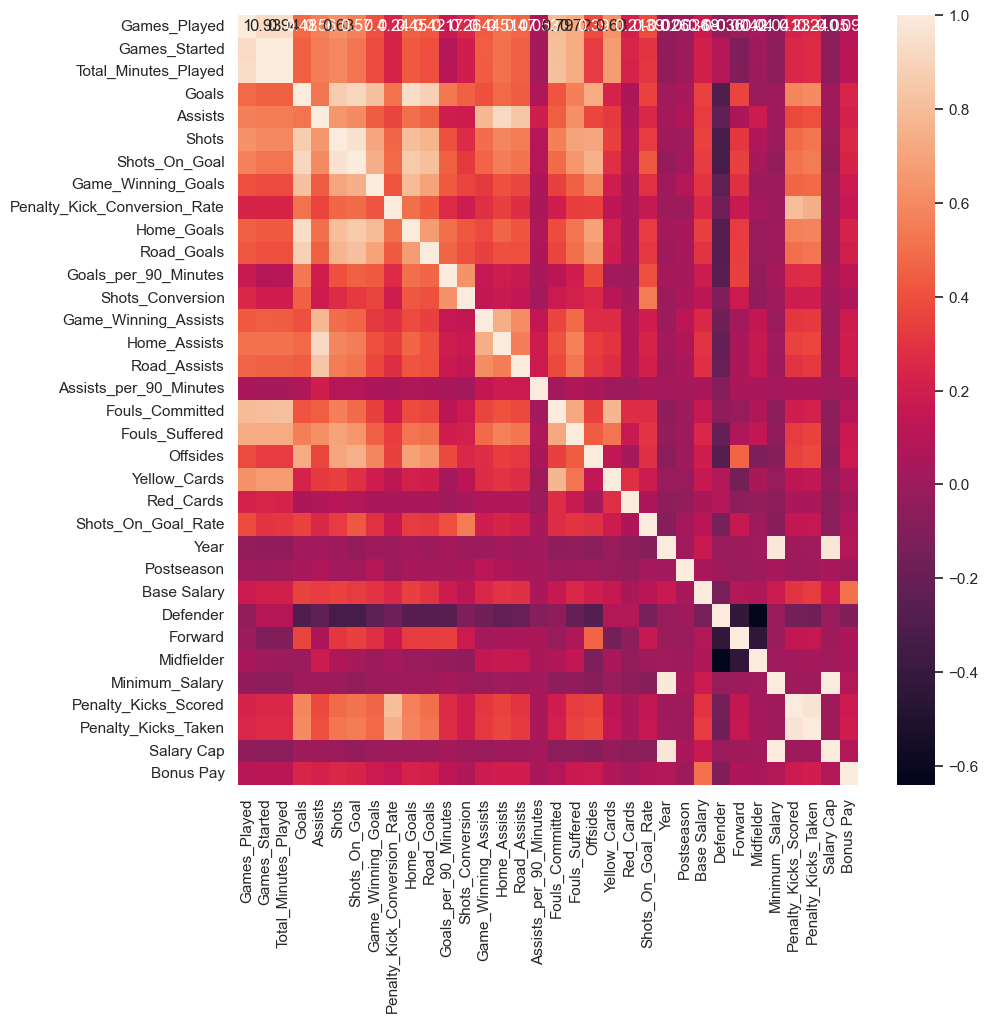

In [119]:
sns.set(rc={'figure.figsize': (10, 10)})

sns.heatmap(stats_salaries_df.corr(), annot=True);

## Modeling 

During the modeling process,  I took a look at the  MSE, RMSE, MAE, and r2. The RMSE, MAE and r2 values held the most significance throughout the process, with the difference in the RMSE and MAE explaining how large some of the errors in  predicting salary are, and the r2 explaining how much of the variance in salary is explained by the features implemented.

I trained the data on multiple predictive models with several iterations. Two of the models required scaling so I used StandardScaler. All of the models utilized a Pipeline with Principal Component Analysis, and were tuned with hyperparameter selection in GridSearchCV. 

Ultimately, the Random Forest Regression model performed the best, predicting player salary with a Mean Absolute Error

### Creating Train Test Split for Base Salary

All modeling will be done on the training data. After choosing the model with the best RMSE and r2, I will evaluate on testing data.

In [120]:
# Splitting our data into independent variable X and dependent variable y
X = stats_salaries_df.drop(columns='Base Salary')
y = stats_salaries_df['Base Salary']

# Running a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Dummy Model

Settting a Dummy model to create a baseline.

In [121]:
# Instantiating and fitting a dummy, or baseline, regression model
dummy = DummyRegressor()
dummy.fit(X_train, y_train)

DummyRegressor()

As expected, all evaluation metric scores below are absolutely terrible.

In [122]:
# Creating y_pred to plot and see how dummy predicts
y_pred = dummy.predict(X_train)

# Dummy r2 score
dummy_score = r2_score(y_train, y_pred)
dummy_score

0.0

In [123]:
dummy_mse_train = mean_squared_error(y_train, y_pred)
dummy_mse_train

351729327337.52454

In [124]:
# Setting up a kfold to cross-validate the scores from each model
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Dummy Mean Squared Error
dummy_mse = np.mean(cross_val_score(dummy, X_train, y_train, cv=kf, scoring='neg_mean_squared_error'))
dummy_mse

-351949694371.2107

In [125]:
dummy_rmse_train = np.sqrt(dummy_mse_train)
dummy_rmse_train

593067.7257594824

In [126]:
# Dummy Root Mean Squared Error
dummy_rmse = np.mean(cross_val_score(dummy, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error'))
dummy_rmse

-586582.9156247482

In [127]:
dummy_mae_train = mean_absolute_error(y_train, y_pred)
dummy_mae_train

252908.180404865

In [128]:
# Dummy Mean Absolute Error
dummy_mae = np.mean(cross_val_score(dummy, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error'))
dummy_mae

-252992.57324805102

### Linear Regression
I started model analyisis with Linear Regression because its a relatively straightforward model to instantiate.
The Linear Regression was not chosen as the final model, as it had a poor r2 score.

#### Instantiating the Model


In [129]:
# Setting up our first model
lr = LinearRegression()
scaler = StandardScaler()
X_train_sc= scaler.fit_transform(X_train)
X_test_sc= scaler.transform(X_test)

lr.fit(X_train_sc, y_train)
y_pred = lr.predict(X_train_sc)

In [130]:
y_pred_lr = lr.predict(X_train_sc)

lr_score_train = r2_score(y_train, y_pred_lr)
lr_score_train

0.3697446780587472

In [131]:
lr_score =  np.mean(cross_val_score(lr, X_train_sc, y_train, cv=kf, scoring = 'r2'))
lr_score

0.2815086321898012

In [132]:
lr_mse_train = mean_squared_error(y_train, y_pred_lr)
lr_mse_train

221679280437.2918

In [133]:
lr_mse = np.mean(cross_val_score(lr, X_train_sc, y_train, cv=kf, scoring = 'neg_mean_squared_error'))
lr_mse

-244586250369.50238

In [134]:
lr_rmse_train = np.sqrt(lr_mse_train)
lr_rmse_train

470828.29188281775

In [135]:
lr_rmse = np.mean(cross_val_score(lr, X_train_sc, y_train, cv=kf, scoring = 'neg_root_mean_squared_error'))
lr_rmse

-491171.03951882955

In [136]:
lr_mae_train = mean_absolute_error(y_train, y_pred_lr)
lr_mae_train

184603.25402650362

In [137]:
lr_mae =  np.mean(cross_val_score(lr, X_train_sc, y_train, cv=kf, scoring = 'neg_mean_absolute_error'))
lr_mae

-188143.12087777266

#### Data Processing through a Pipeline
All of the models were run through a Pipeline with Principal Component Analysis. The initial linear regression cross_validated r2 of .28 was far too low.

In [138]:
pipe = Pipeline([
    ('pca', PCA(random_state=42)),
    ('lr', LinearRegression())
])
    

### Parameter Tuning with GridSearchCV


In [139]:
#Defining parameter grid
param_grid = {
    'pca__n_components': [10, 20, 30],
    'pca__copy': [False, True],
    'pca__whiten': [False, True]
}   

In [140]:
grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
grid.fit(X_train_sc, y_train)
print(grid.best_estimator_)
print(grid.best_score_)

Pipeline(steps=[('pca', PCA(copy=False, n_components=30, random_state=42)),
                ('lr', LinearRegression())])
0.3205098950209747


After the first GridSearch, r2 improves slightly but its still very low at .32.

In [141]:
param_grid = {
    'pca__n_components': [30, 32, 33],
    'pca__copy': [False, True],
    'pca__whiten': [False, True]
}   

In [142]:
grid = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5)
grid.fit(X_train_sc, y_train)
print(grid.best_estimator_)
print(grid.best_score_)

Pipeline(steps=[('pca',
                 PCA(copy=False, n_components=33, random_state=42,
                     whiten=True)),
                ('lr', LinearRegression())])
0.3217249452378338


Nearly identical. We're not getting anywhere with Linear Regression unfortunately.

In [143]:
lpipe = Pipeline(steps=[('pca',
                 PCA(copy=False, n_components=30, random_state=42, whiten=False)),
                ('lr', LinearRegression())])

In [144]:
lpipe.fit(X_train_sc, y_train)
y_pred_lr = lpipe.predict(X_train_sc)
mae = mean_absolute_error(y_train, y_pred_lr)
mae

184603.2540265036

Mean Absolute error is too high, some players don't make that salary in a year.

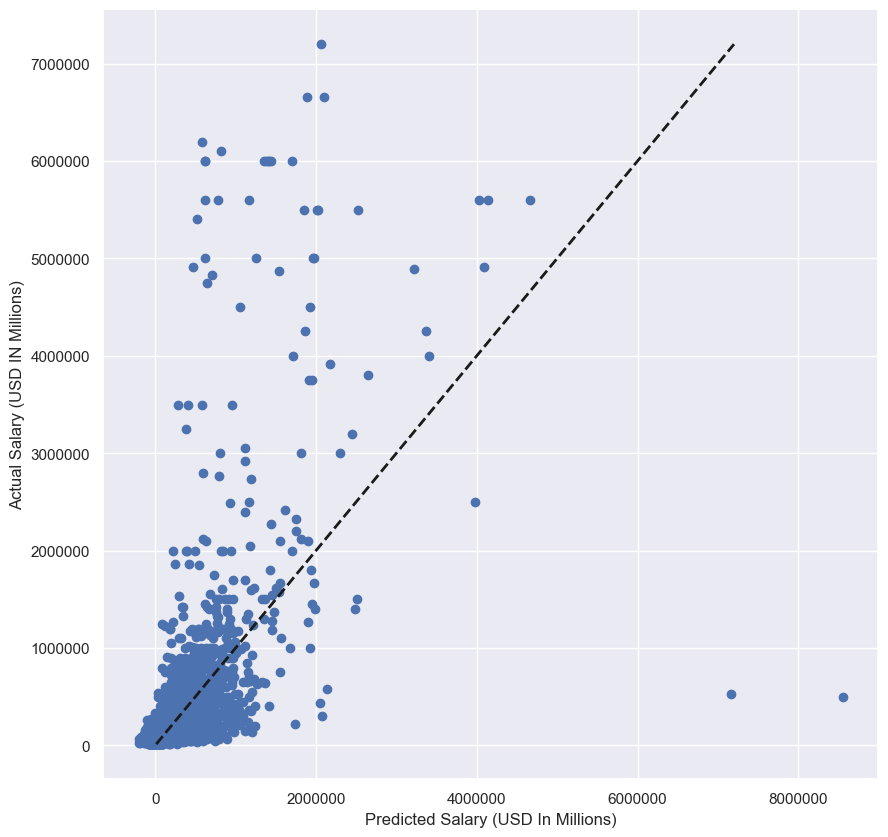

In [145]:
plt.scatter(y_pred_lr, y_train)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Predicted Salary (USD In Millions)')
plt.ylabel('Actual Salary (USD IN Millions)')

plt.ticklabel_format(style='plain')
plt.show()

I plotted a comparison of my model's predicted salary vs a player's actual salary, and it failing to predict across the board but especially when predicting highly paid players.

### Random Forest Model 
I ran a Random Forest Regression next, which was chosen as my final model. I produced the highest r2 of .53 and a MAE of $146,430.

#### Instantiating the Model

In [146]:
rf = RandomForestRegressor(random_state=42)

rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

I'm skeptical of this score, going to cross-validate.

In [147]:
y_pred_rf = rf.predict(X_train)
rf_score_train = r2_score(y_train, y_pred_rf)
rf_score_train

0.9333981198035985

This makes a lot more sense

In [148]:
rf_score = np.mean(cross_val_score(rf, X_train, y_train, cv=kf))
rf_score

0.522497212488785

In [149]:
rf_mse_train = mean_squared_error(y_train, y_pred_rf)
rf_mse_train

23425834520.894676

In [150]:
rf_mse = np.mean(cross_val_score(rf, X_train, y_train, cv=kf, scoring = 'neg_mean_squared_error'))
rf_mse

-163737977879.1627

In [151]:
rf_rmse_train = np.sqrt(rf_mse_train)
rf_rmse_train

153055.00488678794

In [152]:
rf_rmse = np.mean(cross_val_score(rf, X_train, y_train, cv=kf, scoring = 'neg_root_mean_squared_error'))
rf_rmse

-401649.0437840658

In [153]:
rf_mae_train = mean_absolute_error(y_train, y_pred_rf)
rf_mae_train

54850.92702155867

Slightly better MAE

In [154]:
rf_mae = np.mean(cross_val_score(rf, X_train, y_train, cv=kf, scoring = 'neg_mean_absolute_error'))
rf_mae

-146429.89328143912

#### Data Processing through a Pipeline

In [155]:
rfpipe = Pipeline([('pca', PCA(random_state=42)),
                    ('rf', RandomForestRegressor(random_state=42))])

#### Parameter Tuning with GridSearchCV
To reduce the amount of time to run this notebook, all iterations except the best will be commented out. Overall, the scores of the randomforest regression did not change very much despite the hyperparameter tuning. 

In [156]:
#rf_param_grid = {
#    'pca__n_components': [10, 20, 30],
#    'rf__n_estimators': [10, 50, 100],
#    'rf__min_samples_split': [2, 5, 10],
#    'rf__max_depth': [3, 5, 7],
#    'rf__criterion': ['squared_error', 'friedman_mse', 'poisson']
#}
    

In [157]:
#rf_grid = GridSearchCV(rfpipe, rf_param_grid, cv=5, n_jobs=-1, return_train_score=True)
#rf_grid.fit(X_train, y_train)
#print(rf_grid.best_score_)
#print(rf_grid.best_params_)

In [158]:
#rf_param_grid = {
#    'pca__n_components': [26, 30, 34],
#    'rf__n_estimators': [75, 125, 175],
#    'rf__min_samples_split': [3, 5, 7],
#    'rf__max_depth': [7, 9, 11],
#    'rf__criterion': ['squared_error', 'friedman_mse', 'poisson']
#}
    

In [159]:
#rf_grid = GridSearchCV(rfpipe, rf_param_grid, cv=5, n_jobs=-1, return_train_score=True)
#rf_grid.fit(X_train, y_train)
#print(rf_grid.best_score_)
#print(rf_grid.best_params_)

In [160]:
#rf_param_grid = {
#    'pca__n_components': [30, 32, 33],
#    'rf__n_estimators': [ 110, 125, 140],
#    'rf__min_samples_split': [4, 5, 6],
#    'rf__max_depth': [11, 13, 15],
#    'rf__criterion': ['squared_error', 'friedman_mse', 'poisson']
#}

In [161]:
#rf_grid = GridSearchCV(rfpipe, rf_param_grid, cv=5, n_jobs=-1, return_train_score=True)
#rf_grid.fit(X_train, y_train)
#print(rf_grid.best_score_)
#print(rf_grid.best_params_)

In [162]:
rf_bestpipe = Pipeline([('pca', PCA(n_components=33, random_state=42)),
                    ('rf', RandomForestRegressor(n_estimators=125, min_samples_split=4, criterion='poisson',
                                                 max_depth=13, random_state=42))])

rf_bestpipe_score = .5303806605782893
print(rf_bestpipe_score)

0.5303806605782893


In [163]:
rf_bestpipe.fit(X_train, y_train)
y_pred_test = rf_bestpipe.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
r2_test

0.6077459056550032

In [164]:
mse_test = mean_squared_error(y_test, y_pred_test)
mse_test

104115718011.5532

In [165]:
rmse_test = np.sqrt(mse_test)
rmse_test

322669.6732132619

In [166]:
rf_mae = np.mean(cross_val_score(rf_bestpipe, X_train, y_train, cv=kf, scoring = 'neg_mean_absolute_error'))
rf_mae

-143941.17838955153

In [167]:
mae_test = mean_absolute_error(y_test, y_pred_test)
mae_test

129315.97816978532

In [168]:
rf_feature_importances = rf_bestpipe.named_steps['rf'].feature_importances_
rf_feature_names = X.columns.tolist()
rf_bestpipe.named_steps['rf'].feature_names = rf_feature_names
print(rf_feature_importances)

[0.10836034 0.50062307 0.00969331 0.07906289 0.00976283 0.01320655
 0.01061738 0.00804766 0.00877235 0.01227397 0.0149583  0.00946417
 0.0164376  0.01241066 0.02609513 0.00640837 0.0056723  0.00709796
 0.00762633 0.00605305 0.00653332 0.01103852 0.00607762 0.00714957
 0.00679902 0.00619162 0.00634726 0.01073011 0.03979138 0.0266974
 0.         0.         0.        ]


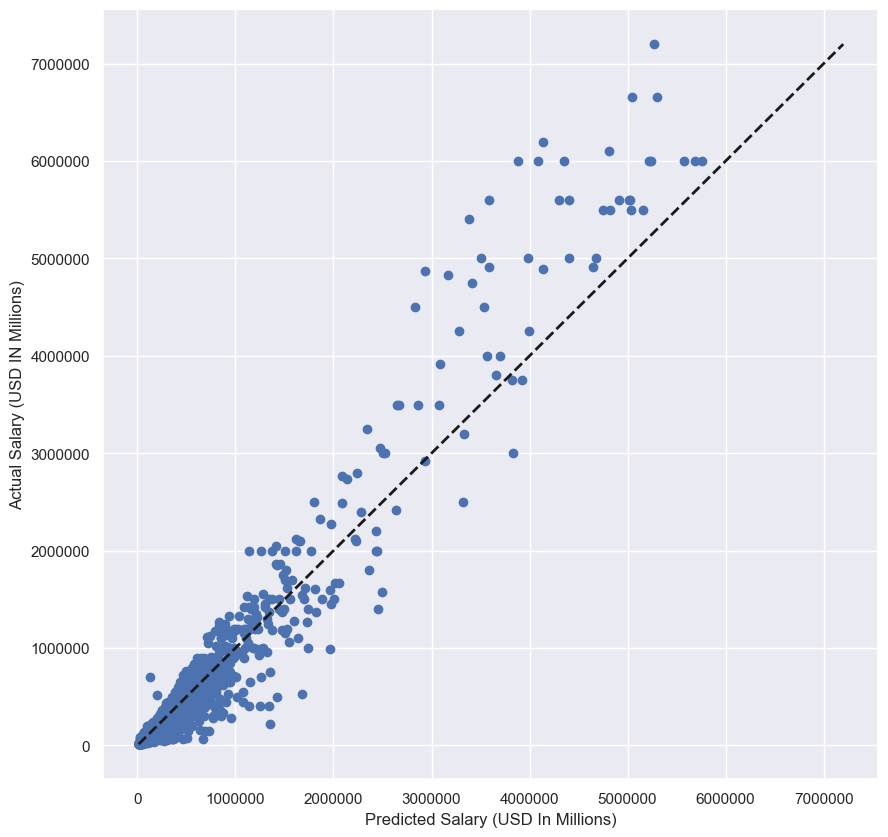

In [169]:
plt.scatter(y_pred_rf, y_train)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Predicted Salary (USD In Millions)')
plt.ylabel('Actual Salary (USD IN Millions)')

plt.ticklabel_format(style='plain')
plt.show()

Talk about how above and below graphs show signs of lower salary players being underpaid and higher salary players being overpayed. Talk about how Designated players get salaries beyond the max. Highlight this on the graphs


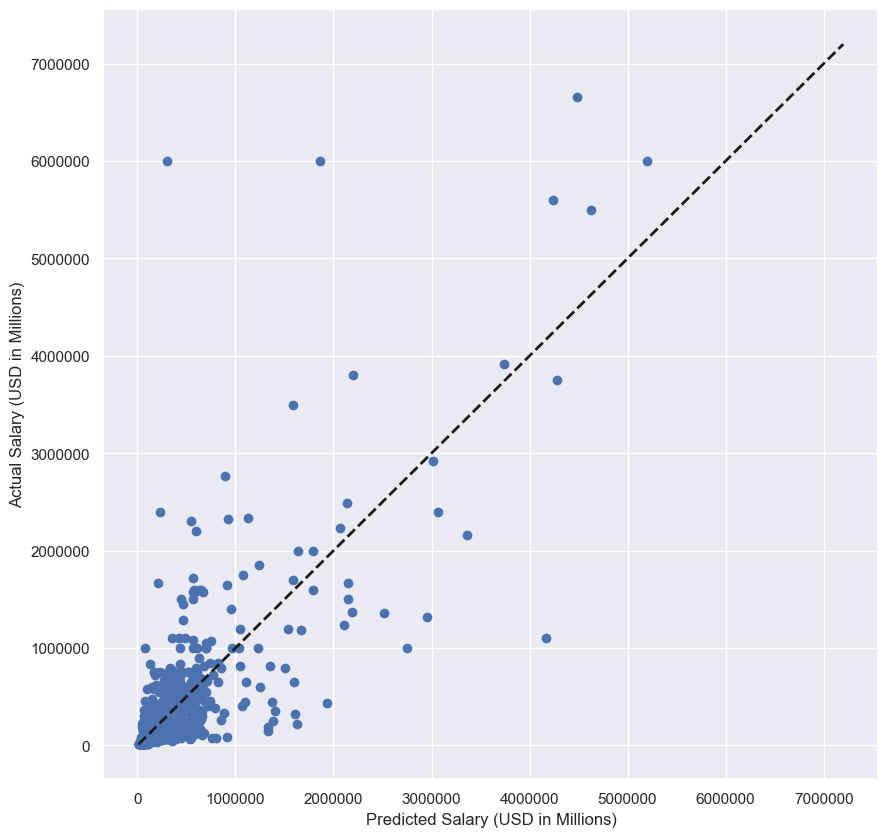

In [170]:
plt.scatter(y_pred_test, y_test)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Predicted Salary (USD in Millions)')
plt.ylabel('Actual Salary (USD in Millions)')

plt.ticklabel_format(style='plain')
plt.show()

In [171]:
# Getting permutation importances for each of the three scoring metrics used
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error']
r_multi = permutation_importance(rf_bestpipe, X_test, y_test,
                           n_repeats=30, random_state=42, scoring=scoring)

for metric in r_multi:
    print(f"{metric}")
    r = r_multi[metric]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0: 
            print(f"    {rf_feature_names[i]: <8}"   
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")

r2
    Bonus Pay0.907 +/- 0.058
    Total_Minutes_Played0.709 +/- 0.035
    Salary Cap0.300 +/- 0.027
    Shots   0.242 +/- 0.023
    Shots_On_Goal0.176 +/- 0.015
    Penalty_Kicks_Taken0.176 +/- 0.020
    Games_Started0.174 +/- 0.013
    Games_Played0.137 +/- 0.019
    Penalty_Kicks_Scored0.125 +/- 0.007
    Minimum_Salary0.102 +/- 0.014
    Goals   0.078 +/- 0.012
    Offsides0.042 +/- 0.010
    Fouls_Committed0.037 +/- 0.014
    Yellow_Cards0.032 +/- 0.014
    Year    0.029 +/- 0.012
    Game_Winning_Goals0.020 +/- 0.004
    Penalty_Kick_Conversion_Rate0.019 +/- 0.005
    Shots_On_Goal_Rate0.012 +/- 0.005
    Assists 0.012 +/- 0.003
    Road_Goals0.008 +/- 0.004
    Road_Assists0.007 +/- 0.002
neg_mean_absolute_percentage_error
    Total_Minutes_Played3.023 +/- 0.086
    Salary Cap1.718 +/- 0.076
    Shots_On_Goal1.020 +/- 0.053
    Shots   1.010 +/- 0.049
    Bonus Pay0.961 +/- 0.130
    Games_Started0.925 +/- 0.025
    Minimum_Salary0.789 +/- 0.022
    Games_Played0.771 +/- 0.029


In [172]:
# Adding permutation importances to respective dataframes
r = r_multi['r2']
r2_df = pd.DataFrame()
r2_df['Feature'] = rf_feature_names
r2_df['Mean'] = r.importances_mean
r2_df['Range +/-'] = r.importances_std

    
r = r_multi['neg_mean_absolute_percentage_error']
mae_df = pd.DataFrame()
mae_df['Feature'] = rf_feature_names
mae_df['Mean'] = r.importances_mean
mae_df['Range +/-'] = r.importances_std


r = r_multi['neg_root_mean_squared_error']
rmse_df = pd.DataFrame()
rmse_df['Feature'] = rf_feature_names
rmse_df['Mean'] = r.importances_mean
rmse_df['Range +/-'] = r.importances_std

In [173]:
# Saving dataframes as csv's to utilize in Tableau
r2_df.to_csv('./data/r2_importances.csv')
mae_df.to_csv('./data/mae_importances.csv')
rmse_df.to_csv('./data/rmse_importances.csv')

### KNearestNeighbors Model
The KnearestNeighbors Model performed better than the Linear Regression, yet still was low in comparision to the random forest.

In [174]:
knn = KNeighborsRegressor()
knn.fit(X_train_sc, y_train)

KNeighborsRegressor()

In [175]:
y_pred_k = knn.predict(X_train_sc)
knn_train = r2_score(y_train, y_pred_k)
knn_train

0.5943928046530214

In [176]:
knn_score = np.mean(cross_val_score(knn, X_train_sc, y_train, cv=kf, scoring = 'r2'))
knn_score

0.2999068736927998

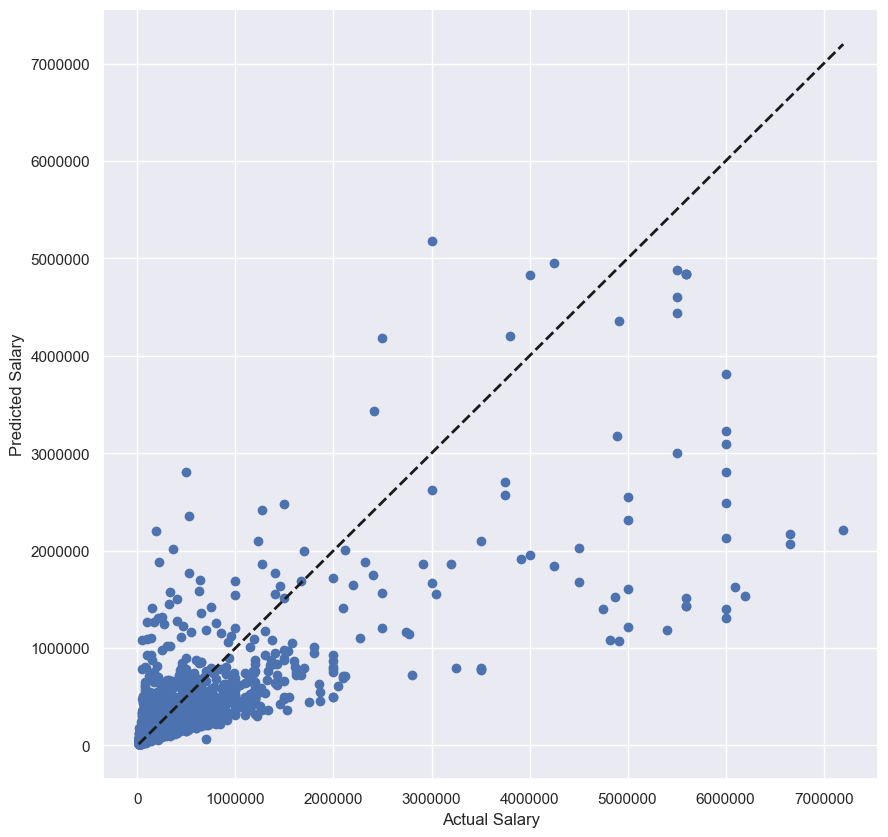

In [177]:
plt.scatter(y_train, y_pred_k)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')

plt.ticklabel_format(style='plain')
plt.show()

In [178]:
knn_mse_train = mean_squared_error(y_train, y_pred_k)
knn_mse_train

142663945982.65268

In [179]:
knn_mse = np.mean(cross_val_score(knn, X_train_sc, y_train, cv=kf, scoring = 'neg_mean_squared_error'))
knn_mse

-241934679434.2892

In [180]:
knn_rmse_train = np.sqrt(knn_mse_train)
knn_rmse_train

377708.8111001022

In [181]:
knn_rmse = np.mean(cross_val_score(knn, X_train_sc, y_train, cv=kf, scoring = 'neg_root_mean_squared_error'))
knn_rmse

-487446.5752763442

In [182]:
knn_mae_train = mean_absolute_error(y_train, y_pred_k)
knn_mae_train

133177.32150822508

In [183]:
knn_mae = np.mean(cross_val_score(knn, X_train_sc, y_train, cv=kf, scoring = 'neg_mean_absolute_error'))
knn_mae

-171218.82580389612

#### Data Processing through a Pipeline


In [184]:
kpipe = Pipeline([('pca', PCA(random_state=42)),
                  ('knn', KNeighborsRegressor())
                 ])
                   

#### Parameter Tuning With GridSearchCV

In [185]:
k_param_grid = {
    'pca__n_components': [5, 10, 15],
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'euclidean', 'manhattan']
}

In [186]:
k_grid = GridSearchCV(kpipe, k_param_grid, n_jobs=-1, cv=5, return_train_score=True)
k_grid.fit(X_train_sc, y_train)
print(k_grid.best_score_)
print(k_grid.best_params_)

0.34193775635392526
{'knn__metric': 'minkowski', 'knn__n_neighbors': 7, 'knn__weights': 'distance', 'pca__n_components': 15}


In [187]:
k_param_grid = {
    'pca__n_components': [7, 10, 13],
    'knn__n_neighbors': [7, 15, 23],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'euclidean', 'manhattan']
}

In [188]:
k_grid = GridSearchCV(kpipe, k_param_grid, n_jobs=-1, cv=5, return_train_score=True)
k_grid.fit(X_train_sc, y_train)
print(k_grid.best_score_)
print(k_grid.best_params_)

0.36772822121955256
{'knn__metric': 'minkowski', 'knn__n_neighbors': 7, 'knn__weights': 'distance', 'pca__n_components': 13}


In [189]:
k_param_grid = {
    'pca__n_components': [3, 5, 7],
    'knn__n_neighbors': [17, 20, 23],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'euclidean', 'manhattan']
}

In [190]:
k_grid = GridSearchCV(kpipe, k_param_grid, n_jobs=-1, cv=5, return_train_score=True)
k_grid.fit(X_train_sc, y_train)
print(k_grid.best_score_)
print(k_grid.best_params_)

0.20584409704069734
{'knn__metric': 'minkowski', 'knn__n_neighbors': 20, 'knn__weights': 'distance', 'pca__n_components': 7}


## Model Selection

### The Best Model
The Random Forest Regression model clearly outperforms the other two and is the most promising to build upon further for the MLSPA.